## Overview

This notebook is a guided tutorial under IBM. The objective is to train a deep neural network to classify cancer cell samples under the Breast Cancer Wisconsin (Diagnostic) dataset. The dataset is divided into two classes: benign (B) and malignant (M). There are 30 features and 569 samples.

## Import Libraries

In [2]:
# get dataset
from ucimlrepo import fetch_ucirepo 

# operational libraries
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# modeling
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim


## Load the Data

In [3]:
# fetch the dataset
bcwd = fetch_ucirepo(id=17)

# split dataset into features and target
X = bcwd.data.features
y = bcwd.data.targets

# examine feature and target columns
display(X.head())
display(y.head())


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,Diagnosis
0,M
1,M
2,M
3,M
4,M


Verify the shape of the dataset

In [4]:
display(f'X shape: {X.shape}')
display(f'y shape: {y.shape}')

'X shape: (569, 30)'

'y shape: (569, 1)'

Check the distribution of the target variable to determine whether the target is unbalanced.

In [5]:
y.value_counts()

Diagnosis
B            357
M            212
Name: count, dtype: int64

Since the target is unbalanced, 200 random samples from each class will be used for model training.

In [6]:
# combine features and target into a pandas DataFrame
bc_data = pd.concat([X, y], axis=1)

# split the dataset on the class difference
bc_data_B = bc_data[bc_data['Diagnosis']=='B']
bc_data_M = bc_data[bc_data['Diagnosis']=='M']

# get a sample of 200 random values for each dataset split
bc_data_B_sample = bc_data_B.sample(n=200, random_state=42)
bc_data_M_sample = bc_data_M.sample(n=200, random_state=42)

# combine the splits for a balanced DataFrame
bc_data_balanced = pd.concat([bc_data_B_sample, bc_data_M_sample])

# verify the class balance
bc_data_balanced['Diagnosis'].value_counts()

Diagnosis
B    200
M    200
Name: count, dtype: int64

## Data Preprocessing

Before modeling the data must be transformed:
- the target and features must be separated
- the target will be mapped to a binary label
- the data will be split into training and testing sets
- 80% of the data will be used for training and 20% for testing
- features will be standardized (different units)


In [7]:
# separate the target and feature columns
X = bc_data_balanced.copy()
y = X.pop('Diagnosis')

# map the target to a binary label
y = y.map({'B':0, 'M':1})

# view transformation
display(X.head())
display(y.head())

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
395,14.060,17.18,89.75,609.1,0.08045,0.05361,0.026810,0.03251,0.1641,0.05764,...,14.92,25.34,96.42,684.5,0.10660,0.12310,0.08460,0.07911,0.2523,0.06609
110,9.777,16.99,62.50,290.2,0.10370,0.08404,0.043340,0.01778,0.1584,0.07065,...,11.05,21.47,71.68,367.0,0.14670,0.17650,0.13000,0.05334,0.2533,0.08468
481,13.900,19.24,88.73,602.9,0.07991,0.05326,0.029950,0.02070,0.1579,0.05594,...,16.41,26.42,104.40,830.5,0.10640,0.14150,0.16730,0.08150,0.2356,0.07603
493,12.460,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,13.19,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028
136,11.710,16.67,74.72,423.6,0.10510,0.06095,0.035920,0.02600,0.1339,0.05945,...,13.33,25.48,86.16,546.7,0.12710,0.10280,0.10460,0.06968,0.1712,0.07343


395    0
110    0
481    0
493    0
136    0
Name: Diagnosis, dtype: int64

In [8]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert the sets to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# create a DataLoader for training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


## Build the Neural Network

To build the neural network, there must be:
- a neural network architecture 
- a loss function
- an optimizer

The model will be derived from the `nn.Module` class from PyTorch, consisting of an input layer, a hidden layer, and an output layer with 2 neurons representing the two classes.

In [9]:
class NNClassifier(nn.Module):
    def __init__(self, input=30, hidden=64, output=2):
        super(NNClassifier, self).__init__()
        self.fc1 = nn.Linear(input, hidden) # first fully connected layer
        self.fc2 = nn.Linear(hidden, output) # second fully connected layer
    
    # make predictions with ReLU activation
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# instantiate the model
model = NNClassifier()

# examine the model architecture
model

NNClassifier(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

Define a loss function and optimizer. Use `CrossEntropyLoss` for the loss function as this is a multi-class classification problem. Use the `Adam` optimizer to update model weights during training.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model Training

The model will undergo 10 training epochs. The weights will be updated with backpropagation. The loss will be examined for each epoch and it should decrease as the model learns to correctly identify the classes. The model performance will then be evaluated on unseen (testing) data.

In [11]:
def model_training(model, criterion, optimizer, epochs):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch) # calculate loss
            loss.backward() 
            optimizer.step()
            running_loss += loss.item() # update loss

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # evaluation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

In [12]:
train_losses, test_losses = model_training(model=model, criterion=criterion, optimizer=optimizer, epochs=10)

Epoch [1/10], Train Loss: 0.3037, Test Loss: 0.1988
Epoch [2/10], Train Loss: 0.1222, Test Loss: 0.1447
Epoch [3/10], Train Loss: 0.0906, Test Loss: 0.1245
Epoch [4/10], Train Loss: 0.0801, Test Loss: 0.1173
Epoch [5/10], Train Loss: 0.0710, Test Loss: 0.1117
Epoch [6/10], Train Loss: 0.0648, Test Loss: 0.1104
Epoch [7/10], Train Loss: 0.0594, Test Loss: 0.1083
Epoch [8/10], Train Loss: 0.0553, Test Loss: 0.1042
Epoch [9/10], Train Loss: 0.0509, Test Loss: 0.1036
Epoch [10/10], Train Loss: 0.0462, Test Loss: 0.1067


## Visualize the Training and Test Loss

Using matplotlib, the loss functions for training and testing can be better intepreted.

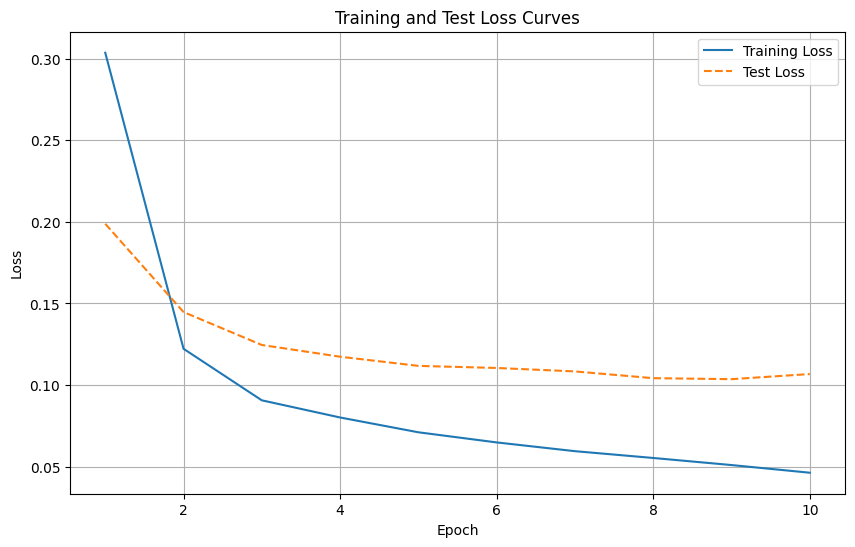

In [15]:
def plot_loss(epochs, train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

epochs=10
plot_loss(epochs, train_losses, test_losses)

## Change the Optimizer: SGD

Stochastic Gradient Descent (SGD) optimizes a loss function by iteratively updating model parameters in the direction of the negative gradient. SGD can be configured in PyTorch with `torch.optim.SGD`.

In [16]:
model_sgd = NNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.09, weight_decay=0.0001)
epochs=10
train_losses, test_losses = model_training(model=model_sgd, criterion=criterion, optimizer=optimizer, epochs=epochs)

Epoch [1/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [2/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [3/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [4/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [5/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [6/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [7/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [8/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [9/10], Train Loss: 0.5934, Test Loss: 0.6119
Epoch [10/10], Train Loss: 0.5934, Test Loss: 0.6119


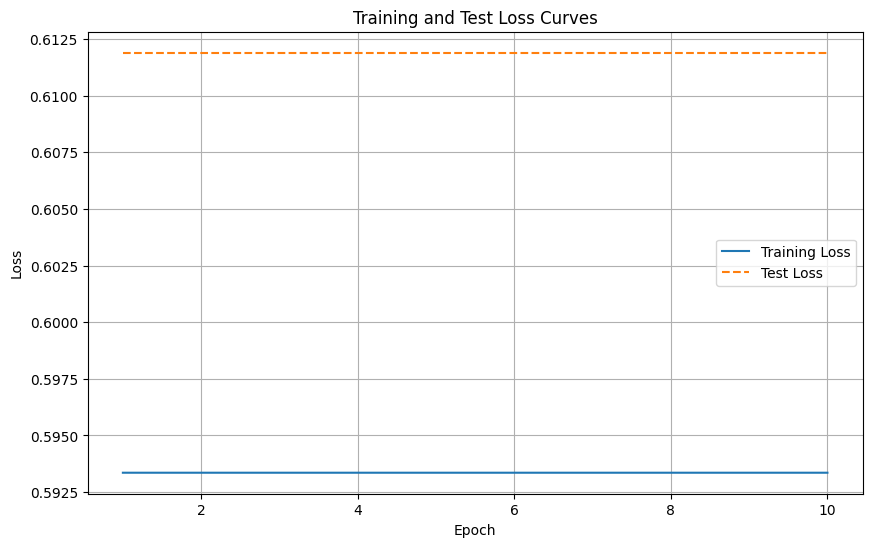

In [17]:
plot_loss(epochs, train_losses, test_losses)

This model does not show a decrease in either loss function, so the Adam optimizer is preferred for this lab.

## Change the number of neurons

Defining a new model architecture will impact its performance

In [18]:
model_2 = NNClassifier(input=30, hidden=15, output=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
epochs=10
train_losses, test_losses = model_training(model=model_2, criterion=criterion, optimizer=optimizer, epochs=epochs)

Epoch [1/10], Train Loss: 0.5241, Test Loss: 0.3387
Epoch [2/10], Train Loss: 0.2110, Test Loss: 0.2219
Epoch [3/10], Train Loss: 0.1434, Test Loss: 0.1850
Epoch [4/10], Train Loss: 0.1198, Test Loss: 0.1566
Epoch [5/10], Train Loss: 0.1045, Test Loss: 0.1420
Epoch [6/10], Train Loss: 0.0954, Test Loss: 0.1303
Epoch [7/10], Train Loss: 0.0884, Test Loss: 0.1232
Epoch [8/10], Train Loss: 0.0833, Test Loss: 0.1188
Epoch [9/10], Train Loss: 0.0781, Test Loss: 0.1180
Epoch [10/10], Train Loss: 0.0748, Test Loss: 0.1163


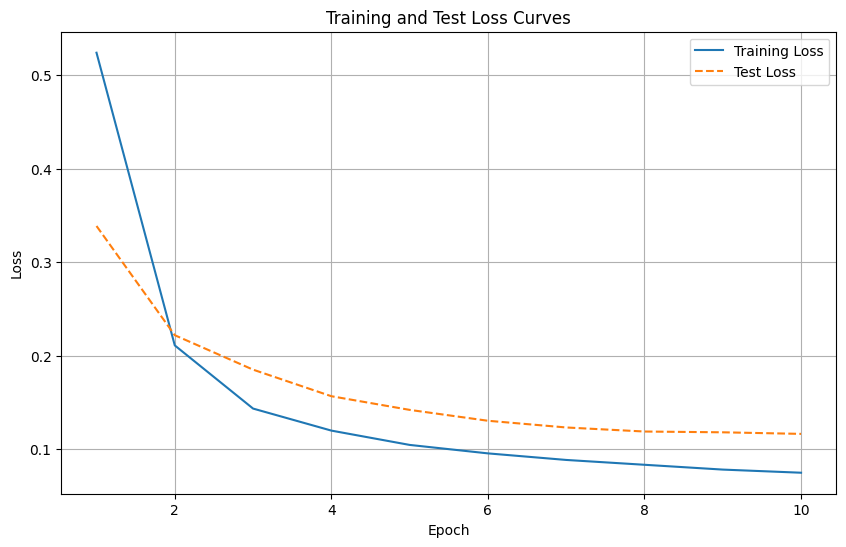

In [19]:
plot_loss(epochs, train_losses, test_losses)